#### Data Loading

In [9]:
import struct
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        if magic != 2051:
            raise ValueError(f'Invalid magic number {magic}, expected 2051')
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape((num_images, rows, cols))
        return images
    
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        if magic != 2049:
            raise ValueError(f'Invalid magic number {magic}, expected 2049')
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels
    
# Load MNIST dataset images and labels
data_path = 'data/MNIST/raw/'
train_images = load_mnist_images(data_path + 'train-images-idx3-ubyte')
test_images = load_mnist_images(data_path + 't10k-images-idx3-ubyte')

train_labels = load_mnist_labels(data_path + 'train-labels-idx1-ubyte')
test_labels = load_mnist_labels(data_path + 't10k-labels-idx1-ubyte')

# Normalize and flatten the input images
# Reshape images to (num_samples, 28*28) and normalize pixel values to [0, 1]
x_train = train_images.reshape(-1, 28*28) / 255.0
x_test = test_images.reshape(-1, 28*28) / 255.0

encoder = OneHotEncoder(sparse_output=False)
# Convert labels from integers to one-hot encoded vectors for training using softmax and cross-entropy loss
# E.g for digit 3, it becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = encoder.fit_transform(train_labels.reshape(-1, 1))
y_test = encoder.transform(test_labels.reshape(-1, 1))

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [10]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
    eps = 1e-10  # avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def mse(y_pred, y_true):
    return np.mean(np.square(y_pred - y_true))

def predict(X):
    logits = np.dot(X, W) + b
    probs = softmax(logits)
    return probs

def sgd(X_batch, Y_batch, probs, W, b, lr=0.01):
    grad_logits = (probs - Y_batch) / X_batch.shape[0]
    grad_W = np.dot(X_batch.T, grad_logits)
    grad_b = np.sum(grad_logits, axis=0, keepdims=True)
    # Update
    W -= lr * grad_W
    b -= lr * grad_b
    return W, b

##### Full-Batch 

In [ ]:
from sklearn.metrics import accuracy_score
np.random.seed(42)

# Weights and biases initialization
W = np.random.randn(28*28, 10) * 0.01
b = np.zeros((1, 10))

# Train using batch gradient descent
epochs = 100
batch_size = 200

# Evaluation metrics
performances = {}

for epoch in range(epochs):
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}")

    # Forward
    logits = np.dot(x_train, W) + b
    probs = softmax(logits)
    train_loss = cross_entropy(probs, y_train)
    train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(probs, axis=1))

    # Backward
    W, b = sgd(x_train, y_train, probs, W, b)  

    # Evaluation after each epoch
    # Test set evaluation
    y_pred = predict(x_test)
    test_loss = cross_entropy(y_pred, y_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    performances[epoch] = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "train_acc": train_acc
    }

# Save performances
import json
with open('sgd.json', 'w') as f:
    json.dump(performances, f, indent=4)


##### Mini-Batch

In [13]:
from sklearn.metrics import accuracy_score
np.random.seed(42)

# Weights and biases initialization
W = np.random.randn(28*28, 10) * 0.01
b = np.zeros((1, 10))

# Train using batch gradient descent
epochs = 100
batch_size = 200

# Evaluation metrics
performances = {}

for epoch in range(epochs):
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}")
    # Shuffle the training data
    permutation = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[permutation]
    y_train_shuffled = y_train[permutation]

    # Train in batches
    train_acc = 0.0
    for i in range(0, x_train.shape[0], batch_size):
        X_batch = x_train_shuffled[i:i+batch_size]
        Y_batch = y_train_shuffled[i:i+batch_size]

        # Forward
        logits = np.dot(X_batch, W) + b
        probs = softmax(logits)
        # train_loss = mse(probs, Y_batch)
        train_loss = cross_entropy(probs, Y_batch)
        train_acc += accuracy_score(np.argmax(Y_batch, axis=1), np.argmax(probs, axis=1))

        # Backward
        W, b = sgd(X_batch, Y_batch, probs, W, b)  

    # Evaluation after each epoch
    train_acc /= (x_train.shape[0] // batch_size)
    # Test set evaluation
    y_pred = predict(x_test)
    test_loss = cross_entropy(y_pred, y_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    performances[epoch] = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "train_acc": train_acc
    }

    # print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, "
    #       f"Test Accuracy={test_acc*100:.2f}%, Train Accuracy={train_acc*100:.2f}%")

# Save performances
import json
with open('sgd_mini_batch.json', 'w') as f:
    json.dump(performances, f, indent=4)


Epoch 1/100


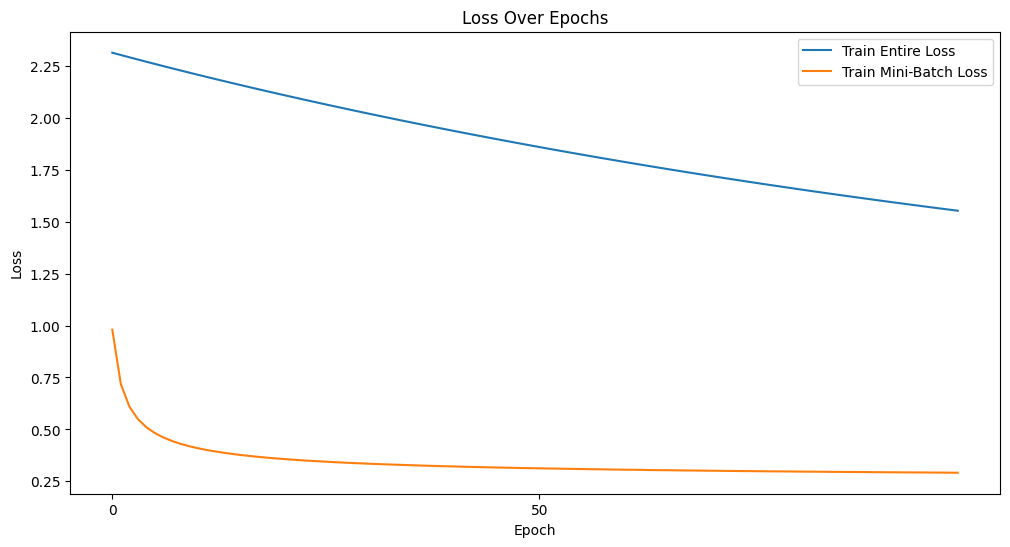

In [ ]:
# Load performances
with open('sgd.json', 'r') as f:
    performances = json.load(f)

with open('sgd_mini_batch.json', 'r') as f:
    performances_mini_batch = json.load(f)

# Convert to pandas DataFrame
import pandas as pd
performances_df = pd.DataFrame(performances).T
performances_df.index.name = 'epoch'
performances_df.reset_index(inplace=True)
performances_df['epoch'] = performances_df['epoch'].astype(int)

performances_mini_batch_df = pd.DataFrame(performances_mini_batch).T
performances_mini_batch_df.index.name = 'epoch'
performances_mini_batch_df.reset_index(inplace=True)
performances_mini_batch_df['epoch'] = performances_mini_batch_df['epoch'].astype(int)

# Visualize
import matplotlib.pyplot as plt
def plot_performance(df1, df2):
    plt.figure(figsize=(12, 6))
    plt.plot(df1['epoch'], df1['test_loss'], label='Test Entire Loss')
    plt.plot(df2['epoch'], df2['test_loss'], label='Test Mini-Batch Loss')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, df1['epoch'].max()+1, step=50))
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()
    plt.close()

plot_performance(performances_df, performances_mini_batch_df)

#### BFGS

In [16]:
import numpy as np
from scipy.optimize import line_search # You might implement your own line search too

def cross_entropy(y_pred, y_true):
    eps = 1e-10  # avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

def gradient_softmax_cross_entropy(y_pred, y_true):
    # Gradient of cross-entropy loss with softmax activation
    return (y_pred - y_true) / y_true.shape[0]

def objective_function(x):
    # Rosenbrock function (common test function)
    # f(x, y) = (1 - x)^2 + 100 * (y - x^2)^2
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def gradient_function(x):
    # Gradient of Rosenbrock function
    dfdx = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
    dfdy = 200 * (x[1] - x[0]**2)
    return np.array([dfdx, dfdy])

##### BFGS Full-Batch 

In [ ]:
from sklearn.metrics import accuracy_score
np.random.seed(42)

# Weights and biases initialization
W = np.random.randn(28*28, 10) * 0.01
b = np.zeros((1, 10))

# Train using batch gradient descent
epochs = 1

# Evaluation metrics
performances = {}

for epoch in range(epochs):
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}")

    # Forward
    probs = softmax(np.dot(x_train, W) + b)
    train_loss = cross_entropy(probs, y_train)
    train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(probs, axis=1))

    # Backward
    W, b = sgd(x_train, y_train, probs, W, b)

    # Evaluation after each epoch
    # Test set evaluation
    y_pred = predict(x_test)
    test_loss = cross_entropy(y_pred, y_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    performances[epoch] = {
        "train_loss": train_loss,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "train_acc": train_acc
    }

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_fn(W, X, y):
    z = X @ W
    p = sigmoid(z)
    loss = -np.mean(y * np.log(p + 1e-10) + (1 - y) * np.log(1 - p + 1e-10))
    return loss

def grad_fn(W, X, y):
    z = X @ W
    p = sigmoid(z)
    grad = X.T @ (p - y) / X.shape[0]
    return grad

def bfgs(X, y, max_iter=100):
    n_features = X.shape[1]
    # Initial weights
    W = np.zeros((n_features, 1))
    H = np.eye(n_features)
    alpha = 1.0

    for i in range(max_iter):
        grad = grad_fn(W, X, y)
        direction = -H @ grad
        W_new = W + alpha * direction
        print((direction).shape)

        grad_new = grad_fn(W_new, X, y)
        s = W_new - W
        y_vec = grad_new - grad
        rho = 1.0 / (y_vec.T @ s + 1e-10)

        # BFGS update
        I = np.eye(n_features)
        print((rho).shape)
        print(f"Shape of s: {s.shape}, Shape of y_vec: {y_vec.shape}, Shape of H: {H.shape}, Shape of I: {I.shape}")
        print((I - rho * s @ y_vec.T).shape)
        print((I - rho * y_vec @ s.T).shape)
        H = (I - rho * s @ y_vec.T) @ H @ (I - rho * y_vec @ s.T) + rho * s @ s.T
        print(f"Shape of H after update: {H.shape}")

        W = W_new

        if i % 10 == 0 or i == max_iter - 1:
            loss = loss_fn(W, X, y)
            print(f"Iter {i}: Loss = {loss:.4f}")

    return W

theta_opt = bfgs(x_train, y_train, max_iter=100)


In [ ]:
# Predict on test set
probs = sigmoid(x_test @ theta_opt)
preds = (probs >= 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test, preds)
print(f"Test Accuracy: {acc * 100:.2f}%")


In [ ]:
epsilon=1e-6
max_iterations=1000

initial_guess = W

x_k = np.array(initial_guess, dtype=float)
n = len(x_k)
H_k = np.eye(n) # Initial inverse Hessian approximation (identity matrix)

k = 0
nabla_f_k = gradient_function(x_k)

print(f"Initial x: {x_k}, f(x): {objective_function(x_k)}, ||grad||: {np.linalg.norm(nabla_f_k)}")

while np.linalg.norm(nabla_f_k) > epsilon and k < max_iterations:
    p_k = -H_k @ nabla_f_k
    alpha_star, fc, gc, new_fval, new_grad, new_a = line_search(
            objective_function, gradient_function, x_k, p_k, gfk=nabla_f_k
        )

2
[[1. 0.]
 [0. 1.]]
Initial x: [-1.2  1. ], f(x): 24.199999999999996, ||grad||: 232.86768775422664


In [53]:
def bfgs_optimizer(x0, f, grad_func, epsilon=1e-6, max_iterations=1000):
    x_k = np.array(x0, dtype=float)
    n = len(x_k)
    H_k = np.eye(n) # Initial inverse Hessian approximation (identity matrix)

    k = 0
    nabla_f_k = grad_func(x_k)
    
    print(f"Initial x: {x_k}, f(x): {f(x_k)}, ||grad||: {np.linalg.norm(nabla_f_k)}")

    while np.linalg.norm(nabla_f_k) > epsilon and k < max_iterations:
        # 1. Compute search direction
        p_k = -H_k @ nabla_f_k

        # 2. Line search to find alpha_k
        # gfk is the gradient at x_k, pk is the search direction
        alpha_star, fc, gc, new_fval, new_grad, new_a = line_search(
            f, grad_func, x_k, p_k, gfk=nabla_f_k
        )

        if alpha_star is None:
            print(f"Line search failed at iteration {k}. Terminating.")
            break

        # 3. Update x_{k+1}
        x_k_plus_1 = x_k + alpha_star * p_k

        # 4. Define s_k and y_k
        s_k = x_k_plus_1 - x_k
        nabla_f_k_plus_1 = grad_func(x_k_plus_1)
        y_k = nabla_f_k_plus_1 - nabla_f_k

        # 5. Check curvature condition
        s_k_dot_y_k = np.dot(s_k, y_k)
        if s_k_dot_y_k <= 0:
            print(f"Curvature condition violated at iteration {k}. s_k.T @ y_k = {s_k_dot_y_k}. Terminating.")
            # You might choose to skip the H_k update or restart H_k here
            break

        # 6. Compute rho_k
        rho_k = 1.0 / s_k_dot_y_k

        # 7. Compute H_{k+1} using BFGS update formula (6.17)
        I_n = np.eye(n)
        term1 = (I_n - rho_k * np.outer(s_k, y_k))
        term2 = (I_n - rho_k * np.outer(y_k, s_k))
        H_k_plus_1 = term1 @ H_k @ term2 + rho_k * np.outer(s_k, s_k)

        # 8. Update for next iteration
        x_k = x_k_plus_1
        nabla_f_k = nabla_f_k_plus_1
        H_k = H_k_plus_1
        k += 1
        
        # Optional: Print progress
        if k % 50 == 0:
             print(f"Iteration {k}: f(x) = {f(x_k):.6f}, ||grad|| = {np.linalg.norm(nabla_f_k):.6f}")

    print(f"\nOptimization finished after {k} iterations.")
    print(f"Final x: {x_k}")
    print(f"Final f(x): {f(x_k)}")
    print(f"Final ||grad||: {np.linalg.norm(nabla_f_k)}")
    
    return x_k, f(x_k), k

# Example usage:
initial_guess = [-1.2, 1.0] # Standard starting point for Rosenbrock

optimal_x, optimal_f, iterations = bfgs_optimizer(
    initial_guess, objective_function, gradient_function, epsilon=1e-6
)

# Verify with scipy's built-in BFGS
from scipy.optimize import minimize
res = minimize(objective_function, initial_guess, method='BFGS', jac=gradient_function)
print("\nSciPy's BFGS result:")
print(f"Optimal x: {res.x}")
print(f"Optimal f(x): {res.fun}")
print(f"Iterations: {res.nit}")

Initial x: [-1.2  1. ], f(x): 24.199999999999996, ||grad||: 232.86768775422664

Optimization finished after 34 iterations.
Final x: [1.00000001 1.00000001]
Final f(x): 4.71529601529797e-17
Final ||grad||: 1.0506606635657992e-07

SciPy's BFGS result:
Optimal x: [0.99999997 0.99999995]
Optimal f(x): 2.535307583394645e-15
Iterations: 32


In [ ]:
X = np.array([1, 2, 9, 12, 21, 33, 24, 45, 67, 89, 100, 123, 145, 167, 189, 200])
import numpy as np
# softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))  # for numerical stability
    return e_x / e_x.sum(axis=0)

def normal_cal(x):
    return x/x.sum()

sm = softmax(X)
nm = normal_cal(X)

print("Softmax:", sm)
print("Normal Cal:", nm)

print("Difference:", np.abs(sm - nm))  # Should be very small, close to zero

Softmax: [3.76175795e-87 1.02255183e-86 1.12136424e-83 2.25232029e-82
 1.82507403e-78 2.97039543e-73 3.66575919e-77 4.83446089e-68
 1.73311210e-58 6.21305582e-49 3.72001385e-44 3.62508037e-34
 1.29955972e-24 4.65880834e-15 1.67014218e-05 9.99983299e-01]
Normal Cal: [0.000815   0.00162999 0.00733496 0.00977995 0.01711491 0.02689487
 0.0195599  0.03667482 0.05460473 0.07253464 0.08149959 0.1002445
 0.11817441 0.13610432 0.15403423 0.16299919]
Difference: [8.14995925e-04 1.62999185e-03 7.33496333e-03 9.77995110e-03
 1.71149144e-02 2.68948655e-02 1.95599022e-02 3.66748166e-02
 5.46047270e-02 7.25346373e-02 8.14995925e-02 1.00244499e-01
 1.18174409e-01 1.36104319e-01 1.54017528e-01 8.36984114e-01]
